In [26]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.utils import load_img,img_to_array
from mtcnn.mtcnn import MTCNN
import face_recognition
import time
from keras.models import load_model
from keras_vggface import utils

In [27]:
names = ["Anudari", "Cebastian", "Chris", "Michael"]
mask_label = ['with mask', 'without mask']

In [28]:
####################
### MASK/NO MASK ###
####################
mask_no_mask_model = tf.keras.models.load_model('../converging_models/MODELS/anudari_mask_nomask_model.h5')
#mask_no_mask_model.summary()

#####################
### UNMASKED FACE ###
#####################
unmasked_model = tf.keras.models.load_model('../converging_models/MODELS/new_nomask_model.h5')
#unmasked_model.summary()

###################
### MASKED FACE ###
###################
masked_model = tf.keras.models.load_model('../converging_models/MODELS/new_mask_model.h5')
#masked_model.summary()

######################
### LOAD DNN MODEL ###
######################
network = cv2.dnn.readNetFromCaffe("../converging_models/MODELS/deploy.prototxt", "../converging_models/MODELS/res10_300x300_ssd_iter_140000_fp16.caffemodel")

In [29]:
##########################################
### DETECT FACE LOCATION USING CV2 DNN ###
##########################################
def dnn_model(image_path):
    dnn_time_start = time.time()
    dnn_label = ''
    scale_factor = 0.3
    confidence_threshold = 0.85
    dnn_boxColor = (0,0,0)
    face_recognition_conf = 0.6

    dnn_image = cv2.imread(image_path)
    dnn_image = cv2.resize(dnn_image, (0,0), fx=scale_factor, fy=scale_factor)


    (height, width) = dnn_image.shape[:2]
    blob = cv2.dnn.blobFromImage(dnn_image, scalefactor=1.0, size=(300, 300), mean=(104.0, 117.0, 123.0))
    network.setInput(blob)
    detections = network.forward()

    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > face_recognition_conf:
            box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
            left = int(box[0])
            top = int(box[1])
            right = int(box[2])
            bottom = int(box[3])

            cropped_image = dnn_image[top:bottom, left:right]

            if cropped_image.size < 1:
                continue

            ###
            new_frame = cv2.resize(cropped_image, (224,224))
            x = image.img_to_array(new_frame)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)

            dnn_prediction = ''

            mask_prediction = mask_no_mask_model.predict(x)

            if mask_label[np.argmax(mask_prediction, axis=1)[0]] == 'with mask':
                dnn_label = 'Masked - '
                dnn_prediction = masked_model.predict(x)
                dnn_boxColor = (255,0,0)
            else:
                dnn_label = 'Unmasked - '
                dnn_prediction = unmasked_model.predict(x)
                dnn_boxColor = (0,0,255)

            prediction_prob = dnn_prediction[0][np.argmax(dnn_prediction, axis=1)[0]]

            if prediction_prob < confidence_threshold:
                dnn_label = dnn_label + "Unknown"
            else :
                dnn_label = dnn_label + names[np.argmax(dnn_prediction, axis=1)[0]]
            ###

            cv2.rectangle(dnn_image, (left - 10, top - 50), (right + 10, bottom + 50), dnn_boxColor, 2)
            cv2.rectangle(dnn_image, (left - 11, top - 49), (right + 11, top -24), dnn_boxColor, cv2.FILLED)
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(dnn_image, dnn_label, (left - 6, top - 26), font, 1.0, (255, 255, 255), 1)

    final_dnn_image = dnn_image
    dnn_time_end = time.time()
    dnn_trt = dnn_time_end - dnn_time_start

    return (final_dnn_image, dnn_trt)

In [30]:
###############################################
### DETECT FACE LOCATION USING HAAR CASCADE ###
###############################################
def haar_model(image_path):
    haar_time_start = time.time()
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    #eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    haar_label = ''
    scale_factor = 0.3
    boxColor = (0,0,0)
    confidence_threshold = 0.85

    haar_image = cv2.imread(image_path)
    haar_image = cv2.resize(haar_image, (0,0), fx=scale_factor, fy=scale_factor)

    faces = face_cascade.detectMultiScale(haar_image)
    #to draw faces on image
    for result in faces:
        left, top, w, h = result
        right, bottom = left + w, top + h

        cropped_image = haar_image[top:bottom, left:right]

        ###
        new_frame = cv2.resize(cropped_image, (224,224))
        x = image.img_to_array(new_frame)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        haar_prediction = mask_no_mask_model.predict(x)

        if mask_label[np.argmax(haar_prediction, axis=1)[0]] == 'with mask':
            haar_label = 'Masked - '
            haar_prediction = masked_model.predict(x)
            boxColor = (255,0,0)
        else:
            haar_label = 'Unmasked - '
            haar_prediction = unmasked_model.predict(x)
            boxColor = (0,0,255)

        prediction_prob = haar_prediction[0][np.argmax(haar_prediction, axis=1)[0]]

        if prediction_prob < confidence_threshold:
            haar_label = haar_label + "Unknown"
        else :
            haar_label = haar_label + names[np.argmax(haar_prediction, axis=1)[0]]
        ###

        cv2.rectangle(haar_image, (left - 10, top - 50), (right + 10, bottom + 50), boxColor, 2)
        cv2.rectangle(haar_image, (left - 11, top - 49), (right + 11, top - 24), boxColor, cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(haar_image, haar_label, (left - 6, top - 26), font, 1, (255, 255, 255), 1)

    final_haar_image = haar_image
    haar_time_end = time.time()
    haar_trt = haar_time_end - haar_time_start

    return (final_haar_image, haar_trt)

In [31]:
########################################
### DETECT FACE LOCATION USING MTCNN ###
########################################
def mtcnn_model(image_path):
    mtcnn_time_start = time.time()
    scale_factor = 0.3
    mtcnn_image = face_recognition.load_image_file(image_path)
    mtcnn_image = cv2.resize(mtcnn_image, (0,0), fx=scale_factor, fy=scale_factor)
    mtcnn_label=''
    mtcnn_boxColor = (0,0,0)
    confidence_threshold = 0.85

    detector = MTCNN()
    location = detector.detect_faces(mtcnn_image)
    for face in location:
        left, top, width, height = face['box']
        right, bottom = left + width, top + height

        cropped_image = mtcnn_image[top:bottom, left:right]

        ###
        new_frame = cv2.resize(cropped_image, (224,224))
        x = image.img_to_array(new_frame)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        mtcnn_prediction = mask_no_mask_model.predict(x)

        if mask_label[np.argmax(mtcnn_prediction, axis=1)[0]] == 'with mask':
            mtcnn_label = 'Masked - '
            mtcnn_prediction = masked_model.predict(x)
            mtcnn_boxColor = (0,0,255)
        else:
            mtcnn_label = 'Unmasked - '
            mtcnn_prediction = unmasked_model.predict(x)
            mtcnn_boxColor = (255,0,0)

        prediction_prob = mtcnn_prediction[0][np.argmax(mtcnn_prediction, axis=1)[0]]

        if prediction_prob < confidence_threshold:
            mtcnn_label = mtcnn_label + "Unknown"
        else :
            mtcnn_label = mtcnn_label + names[np.argmax(mtcnn_prediction, axis=1)[0]]
        
        ###
        cv2.rectangle(mtcnn_image, (left - 10, top - 50), (right + 10, bottom + 50), mtcnn_boxColor, 2)
        cv2.rectangle(mtcnn_image, (left - 11, top - 49), (right + 11, top - 24), mtcnn_boxColor, cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(mtcnn_image, mtcnn_label, (left - 6, top - 26), font, 1, (255, 255, 255), 1)

    final_mtcnn_image = cv2.cvtColor(mtcnn_image, cv2.COLOR_BGR2RGB)
    mtcnn_time_end = time.time()
    mtcnn_trt = mtcnn_time_end - mtcnn_time_start

    return (final_mtcnn_image, mtcnn_trt)

In [32]:
###################################################
### DETECT FACE LOCATION USING FACE_RECOGNITION ###
###################################################
def fr_model(image_path):
    fr_time_start = time.time()
    boxColor = (0,0,0)
    confidence_threshold = 0.85

    face_recognition_image = face_recognition.load_image_file(image_path)
    face_recognition_image = cv2.resize(face_recognition_image, (0,0), fx=scale_factor, fy=scale_factor)
    fr_label=''

    small_frame = cv2.resize(face_recognition_image, (0, 0), fx=0.25, fy=0.25)
    rgb_small_frame = small_frame[:, :, ::-1]
    face_locations = face_recognition.face_locations(rgb_small_frame, model='cnn')
    print(face_locations)

    for (top, right, bottom, left) in face_locations:
        top *=4
        bottom *=4
        left *=4
        right *=4

        cropped_image = face_recognition_image[top:bottom, left:right]
                
        new_frame = cv2.resize(cropped_image, (224,224))
        x = image.img_to_array(new_frame)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        fr_prediction = mask_no_mask_model.predict(x)

        if mask_label[np.argmax(fr_prediction, axis=1)[0]] == 'with mask':
            fr_label = 'Masked - '
            fr_prediction = masked_model.predict(x)
            boxColor = (0,0, 255)
        else:
            fr_label = 'Unmasked - '
            fr_prediction = unmasked_model.predict(x)
            boxColor = (255, 0,0)

        prediction_prob = fr_prediction[0][np.argmax(fr_prediction, axis=1)[0]]

        if prediction_prob < confidence_threshold:
            fr_label = fr_label + "Unknown"
        else :
            fr_label = fr_label + names[np.argmax(fr_prediction, axis=1)[0]]


        cv2.rectangle(face_recognition_image, (left - 10, top - 50), (right + 10, bottom + 50), boxColor, 2)
        cv2.rectangle(face_recognition_image, (left - 11, top - 49), (right + 11, top -24), boxColor, cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(face_recognition_image, fr_label, (left - 6, top - 26), font, 1, (255, 255, 255), 1)

    final_fr_image = cv2.cvtColor(face_recognition_image, cv2.COLOR_BGR2RGB)
    fr_time_end = time.time()
    fr_trt = fr_time_end - fr_time_start

    return (final_fr_image, fr_trt)

In [41]:
#########################
### RECOLORIZE IMAGES ###
#########################
image_path = ('../NEW_DATASET/test/presentation/chris_mask_blocked (2).jpg')


final_dnn_image, dnn_trt = dnn_model(image_path)
final_fr_image, fr_trt = fr_model(image_path)
final_haar_image, haar_trt = haar_model(image_path)
final_mtcnn_image, mtcnn_trt = mtcnn_model(image_path)

final_dnn_image = cv2.cvtColor(final_dnn_image, cv2.COLOR_BGR2RGB)
final_dnn_image = np.array(final_dnn_image)

final_fr_image = cv2.cvtColor(final_fr_image, cv2.COLOR_BGR2RGB)
final_fr_image = np.array(final_fr_image)

final_haar_image = cv2.cvtColor(final_haar_image, cv2.COLOR_BGR2RGB)
final_haar_image = np.array(final_haar_image)

final_mtcnn_image = cv2.cvtColor(final_mtcnn_image, cv2.COLOR_BGR2RGB)
final_mtcnn_image = np.array(final_mtcnn_image)

1/1 [==============================] - 0s 22ms/step
[]
1/1 [==============================] - 0s 22ms/step


Text(0.5, 1.0, 'MTCNN - 1.63s')

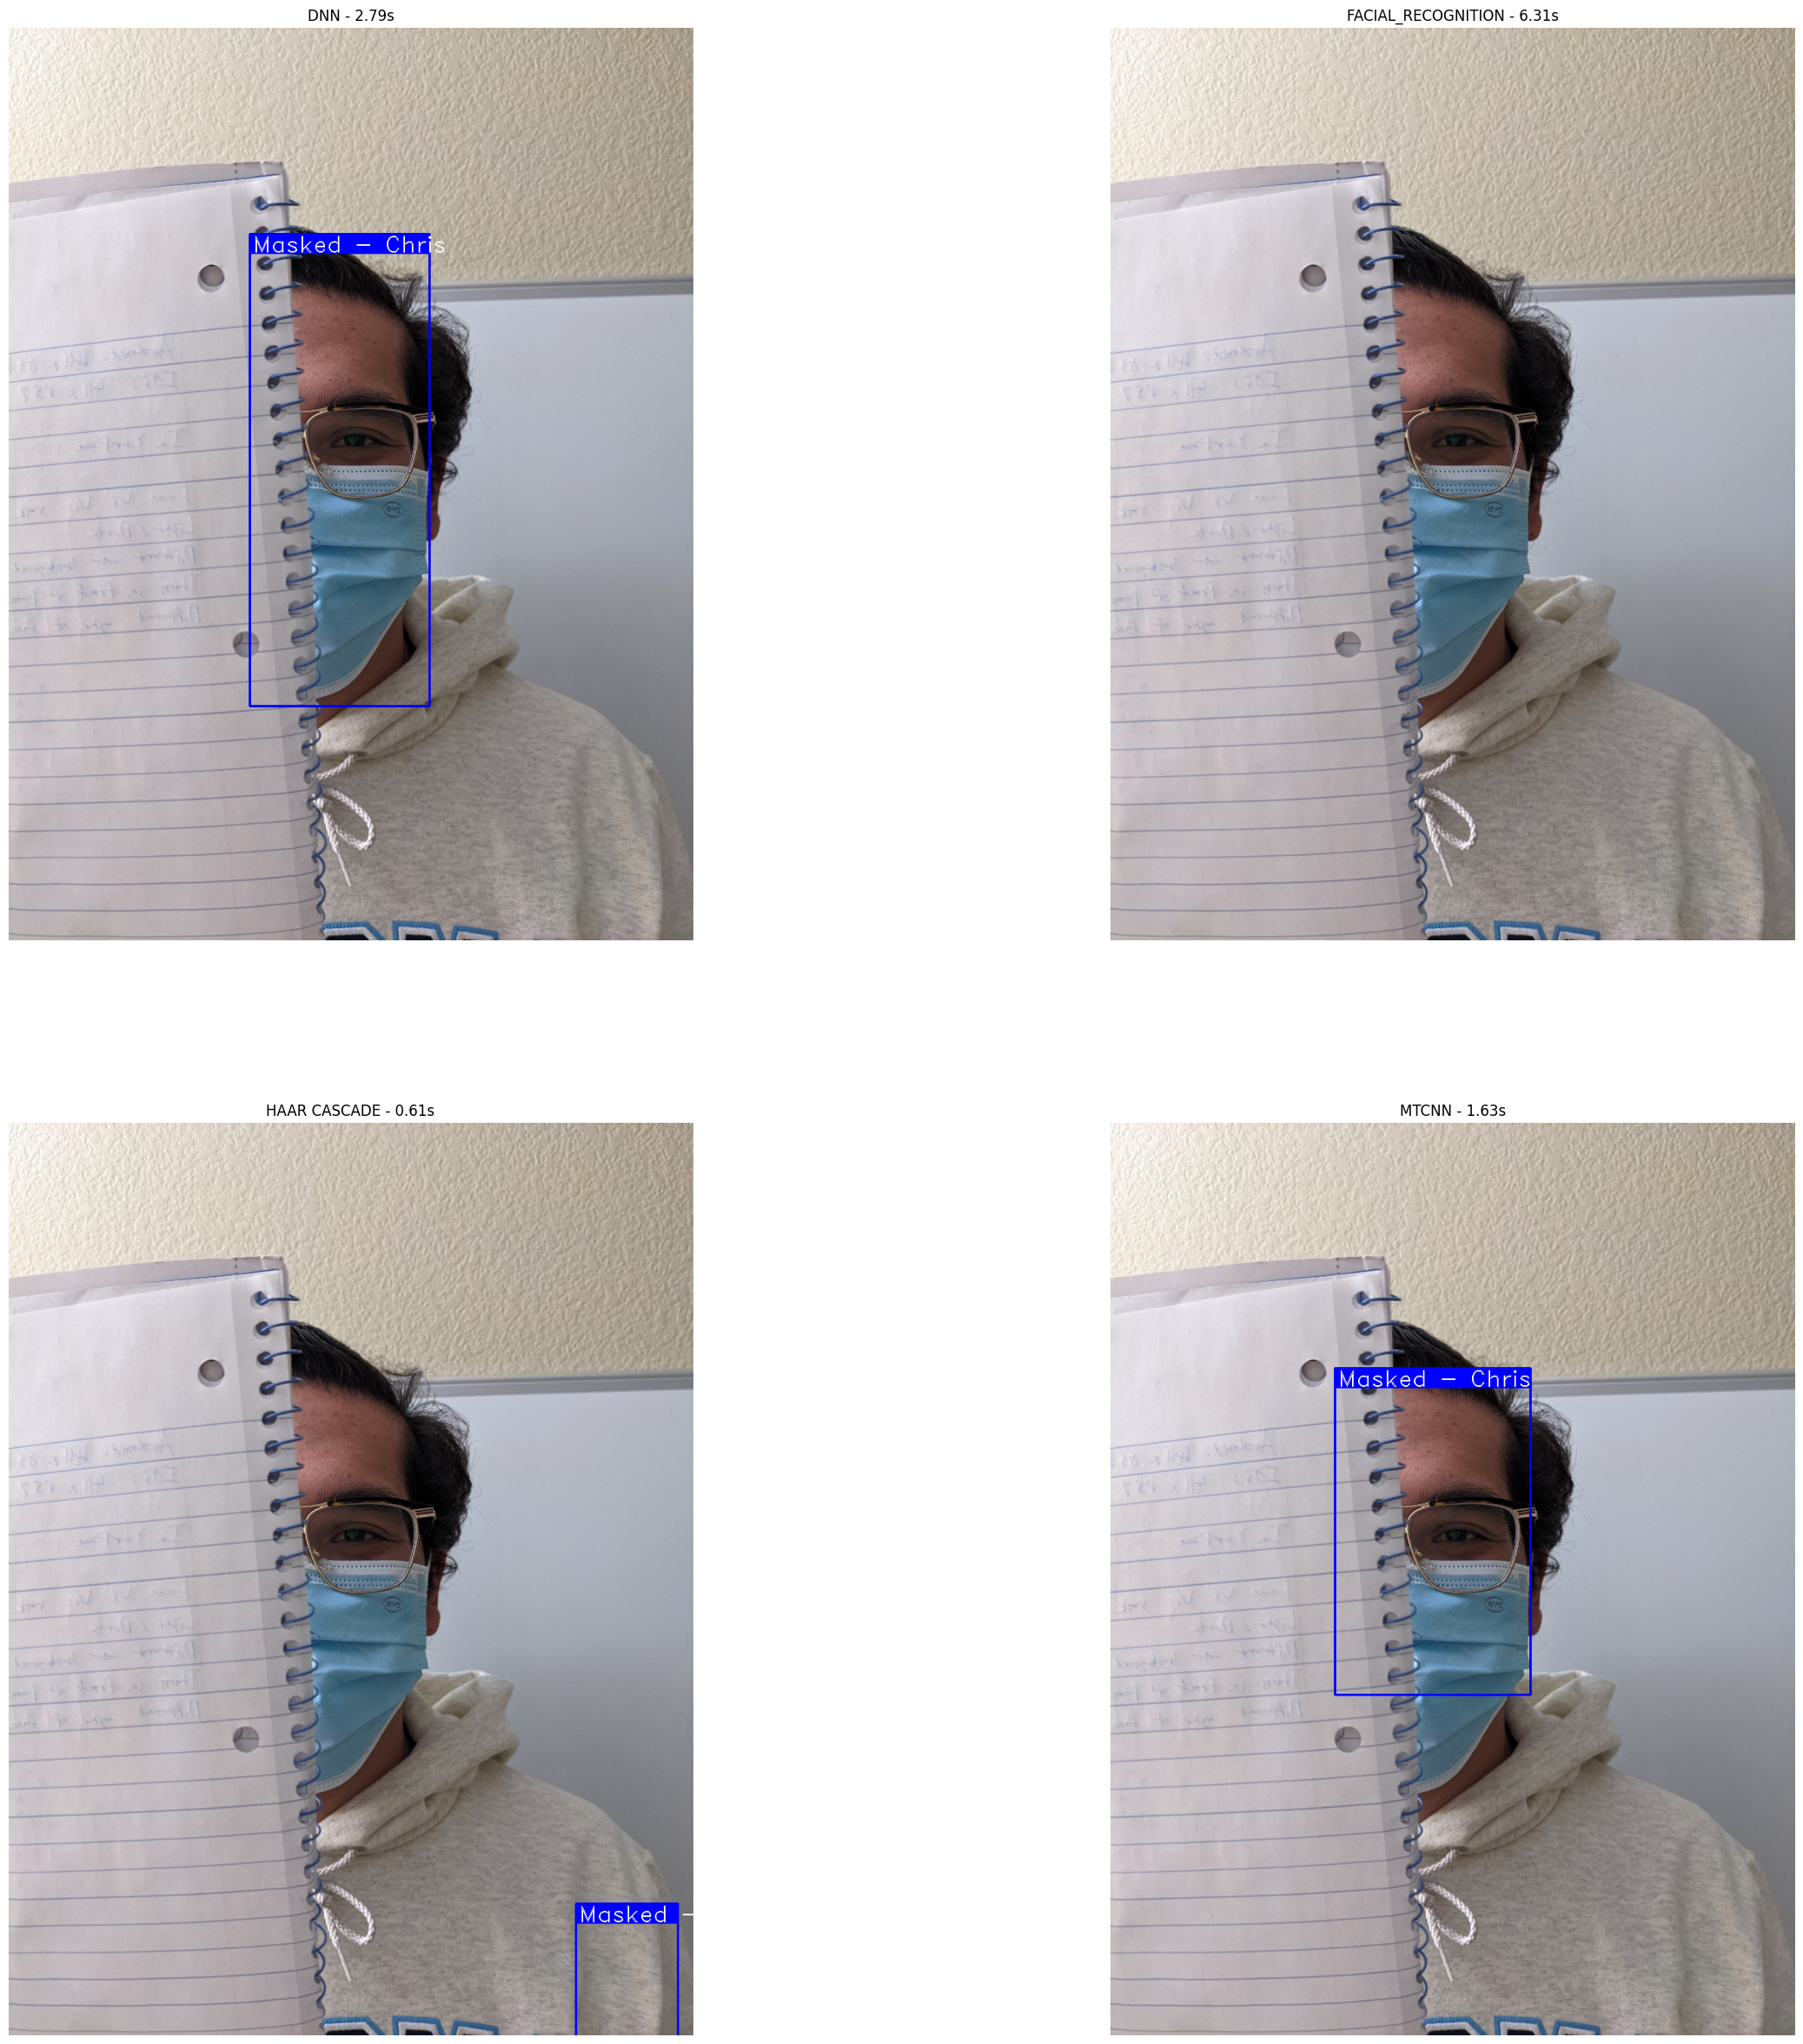

In [42]:
#########################
### PLOT FINAL IMAGES ###
#########################
fig = plt.figure(figsize=(30, 30))
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(final_dnn_image)
plt.axis('off')
plt.title("DNN - " + str(format(dnn_trt, '.2f')) + 's')

fig.add_subplot(rows, columns, 2)
plt.imshow(final_fr_image)
plt.axis('off')
plt.title("FACIAL_RECOGNITION - " + str(format(fr_trt, '.2f')) + 's')

fig.add_subplot(rows, columns, 3)
plt.imshow(final_haar_image)
plt.axis('off')
plt.title("HAAR CASCADE - " + str(format(haar_trt, '.2f')) + 's')

fig.add_subplot(rows, columns, 4)
plt.imshow(final_mtcnn_image)
plt.axis('off')
plt.title("MTCNN - " + str(format(mtcnn_trt, '.2f')) + 's')